In [1]:
! pip3 install torch torchvision torchaudio
! pip3 install numpy
! pip3  install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torchvision
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
from MS_SSIM_L1_loss import MS_SSIM_L1_LOSS
from processing import grey_to_rgb, get_latest_epoch, resume, checkpoint, imshow

### Autoencoder definition:

In [3]:
# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Activation functions
        self.relu = nn.LeakyReLU(0.01)
        self.tanh = nn.Tanh()
        # Encoder
        self.conv1 = nn.Conv2d(
            3, 32, kernel_size=3, stride=1, padding=1
        )  # 96*192 -> 96*192
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(
            32, 64, kernel_size=3, stride=1, padding=1
        )  # 96*192 -> 96*192
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(
            64, 128, kernel_size=4, stride=2, padding=1
        )  # 96*192 -> 48*96
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(
            128, 64, kernel_size=4, stride=2, padding=1
        )  # 48*96 -> 24*48
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(
            64, 8, kernel_size=4, stride=2, padding=1
        )  # 24*48 -> 12*24
        self.bn5 = nn.BatchNorm2d(8)
        self.encoder = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn2,
            self.relu,
            self.conv3,
            self.bn3,
            self.relu,
            self.conv4,
            self.bn4,
            self.relu,
            self.conv5,
            self.bn5,
        )

        # Decoder
        self.t_conv1 = nn.ConvTranspose2d(
            8, 64, kernel_size=4, stride=2, padding=1
        )  # 12*24 -> 24*48
        self.t_conv2 = nn.ConvTranspose2d(
            64, 128, kernel_size=4, stride=2, padding=1
        )  # 24*48 -> 48*96
        self.t_conv3 = nn.ConvTranspose2d(
            128, 64, kernel_size=4, stride=2, padding=1
        )  # 48*96 -> 96*192
        self.t_conv4 = nn.ConvTranspose2d(
            64, 32, kernel_size=3, stride=1, padding=1
        )  # 96*192 -> 96*192
        self.t_conv5 = nn.ConvTranspose2d(
            32, 3, kernel_size=3, stride=1, padding=1
        )  # 96*192 -> 96*192
        self.decoder = nn.Sequential(
            self.t_conv1,
            self.bn4,
            self.relu,
            self.t_conv2,
            self.bn3,
            self.relu,
            self.t_conv3,
            self.bn2,
            self.relu,
            self.t_conv4,
            self.bn1,
            self.relu,
            self.t_conv5,
            self.tanh,
        )

    def forward(self, x):
        # Encoder
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Setting parameters:

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"""
User Inputs
"""
# number of epochs for training
num_epoch = 20
# Loading checkpoint
checkpoint_dir = "./checkpoints"
loading_epoch = get_latest_epoch(checkpoint_dir)
# batch size
batch_size = 64
"""
End of User Inputs
"""
# Load the dataset
transform = transforms.Compose(
    [   transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        transforms.Resize((96, 192), antialias=True),
        transforms.Lambda(grey_to_rgb),
    ]
)
dataset = datasets.Caltech256(
    "./DATA",
    download=True,
    transform=transform,
)
# random seed
random_seed = torch.Generator().manual_seed(42)
# split train and test
train, test = torch.utils.data.random_split(dataset, [0.8, 0.2], generator=random_seed)
# dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)
# check the shape of the data
trainiter = iter(trainloader)
img, label = next(trainiter)
print(img.shape, label.shape) # torch.Size([64, 3, 96, 192]) torch.Size([64])
"""
Model params
"""
model = Autoencoder()
if loading_epoch != 0:
    resume(model, f"{str(checkpoint_dir)}/MS_SSIM_L1-epoch-{str(loading_epoch)}.pth")
else:
    print("No checkpoint found, start training from scratch")
    loading_epoch = 0
total_epoch = num_epoch + loading_epoch
# Move to device
model = model.to(device)
# Set parameters
criterion = MS_SSIM_L1_LOSS()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

1183006720it [00:12, 94661205.38it/s]


Extracting ./DATA/caltech256/256_ObjectCategories.tar to ./DATA/caltech256
torch.Size([64, 3, 96, 192]) torch.Size([64])
No checkpoint found, start training from scratch


### Training:

In [5]:
start_time = time.time()
for e in range(loading_epoch+1, total_epoch+1):
    epoch_loss = 0
    for i, (img_in, _) in enumerate(trainloader):
        img_in = img_in.to(device)
        optimizer.zero_grad()
        img_out = model(img_in)
        loss = criterion(img_in, img_out)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{e}/{total_epoch}], Step [{i+1}/{len(trainloader)}], Loss: {loss.item():.4f}"
            )
    print(f'average loss for epoch {e} is {epoch_loss/len(trainloader):.4f}')
    if e % 10 == 0:
        checkpoint(model, f"{checkpoint_dir+'/'}MS_SSIM_L1-epoch-{e}.pth")
print("Finished Training in time", (time.time() - start_time) / 60, "mins")

Epoch [1/20], Step [100/383], Loss: 38.1881
Epoch [1/20], Step [200/383], Loss: 37.0807
Epoch [1/20], Step [300/383], Loss: 37.5639
average loss for epoch 1 is 47.0134
Epoch [2/20], Step [100/383], Loss: 33.3474
Epoch [2/20], Step [200/383], Loss: 45.2169
Epoch [2/20], Step [300/383], Loss: 32.0766
average loss for epoch 2 is 37.9443
Epoch [3/20], Step [100/383], Loss: 28.2573
Epoch [3/20], Step [200/383], Loss: 38.2407
Epoch [3/20], Step [300/383], Loss: 46.9746
average loss for epoch 3 is 35.1776
Epoch [4/20], Step [100/383], Loss: 33.6127
Epoch [4/20], Step [200/383], Loss: 30.5150
Epoch [4/20], Step [300/383], Loss: 30.5245
average loss for epoch 4 is 34.3100
Epoch [5/20], Step [100/383], Loss: 30.9330
Epoch [5/20], Step [200/383], Loss: 29.6814
Epoch [5/20], Step [300/383], Loss: 42.3508
average loss for epoch 5 is 32.8155
Epoch [6/20], Step [100/383], Loss: 33.9737
Epoch [6/20], Step [200/383], Loss: 28.7009
Epoch [6/20], Step [300/383], Loss: 39.3624
average loss for epoch 6 is 

### Testing:

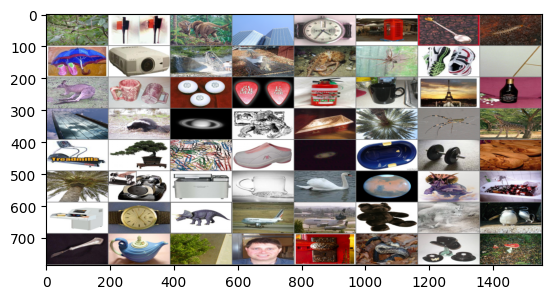

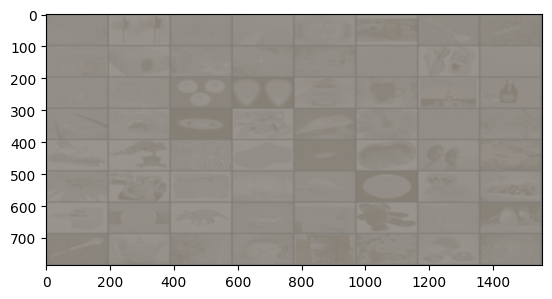

Loss: 95.0091


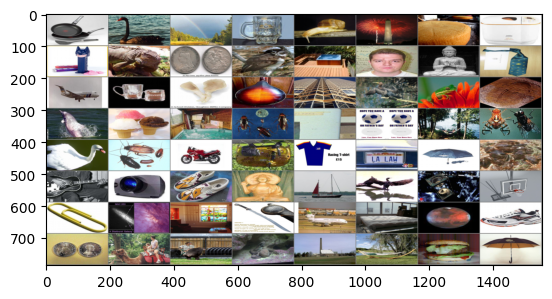

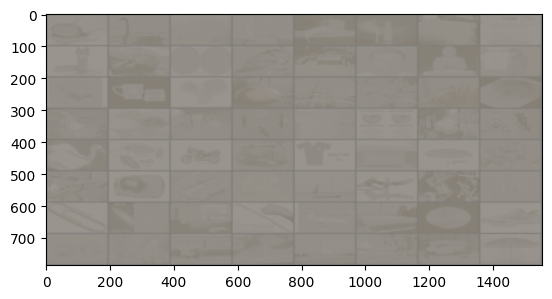

Loss: 98.5010


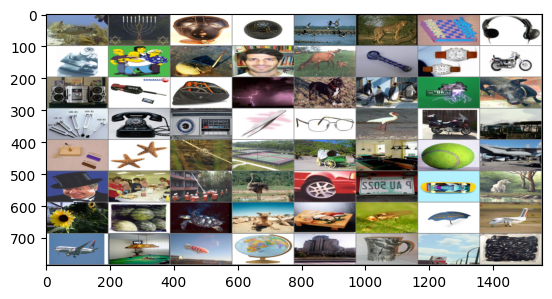

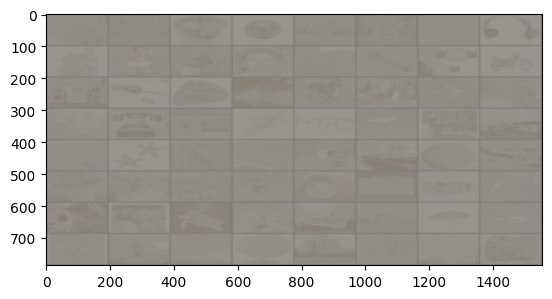

Loss: 94.8074


KeyboardInterrupt: ignored

In [18]:
resume(model, f"{str(checkpoint_dir)}/MS_SSIM_L1-epoch-{str(20)}.pth")
# Reconstruct images
model.eval() 
model = model.to(device)
for i, (img_in, _ )in enumerate(trainloader):
    with torch.no_grad():
        img_out = model(img_in.to(device))
        loss = criterion(img_in.to(device), img_out.to(device)) 
    if i % 100 == 0:
       imshow(torchvision.utils.make_grid(img_in.to("cpu")))
       imshow(torchvision.utils.make_grid(img_out.to("cpu")))
       print(f"Loss: {loss.item():.4f}")
